# On the use of "triangle plots" in trend analysis 

This is the code used to produce the plots presented here: http://fabienmaussion.info/2016/04/29/trendy-triangles/

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats
# Some defaults
cmap = plt.get_cmap('RdBu_r')
sns.set_context('talk')
sns.set_style('ticks')

## The False Discovery Rate analysis

Described first by [Benjamini and Hochberg (1995)](https://www.jstor.org/stable/2346101) and presented in a climatological context by [Wilks (2016)](http://journals.ametsoc.org/doi/pdf/10.1175/BAMS-D-15-00267.1), the FDR approach is straightforward to implement: 

$$p_{FDR} = max_{i=1,...,N} \left[p_i : p_i \le (i / N) \alpha \right]$$

where $p_{FDR}$ is the threshold level that p-values should not exceed, $p_i$ the sorted p-values in the grid and $\alpha$ the threshold chosen originally (0.05 in our previous examples).

In [2]:
def fdr_threshold(pvalues, alpha=0.05):
    """Computes the FDR threshod after Wilks (2016).
    
    Parameters
    ----------
    pvalues : np.array
        The pvalues of the grid.
    alpha : float, default=0.05
        The original threshold.
    
    Returns
    -------
    the threshold p-value
    """
    p = np.sort(np.asarray(pvalues).flatten())
    n = len(p)
    return np.max(np.where(p <= (np.arange(1, n+1) / n * alpha), p, 0))

In [3]:
def plot_fdr_threshold(pvalues, alpha=0.05):
    """Plots the FDR threshod after Wilks (2016)."""
    p = np.sort(np.asarray(pvalues).flatten())
    plt.plot(p, '.', color='C1')
    plt.xlim(1, 6901);
    plt.ylim(0, 0.07);
    n = len(p)
    plt.plot((np.arange(1, n+1) / n * alpha), linestyle='--', color='C2')
    plt.axhline(0.05, linestyle='--', color='grey');
    plt.annotate('$p$=0.05', (100, 0.051), color='grey')
    if p_fdr > 0:
        plt.axhline(p_fdr, linestyle='--', color='grey');
        plt.annotate('$p_{FDR}$'+'={:.2}'.format(p_fdr), (100, p_fdr + 0.001), color='grey');
    plt.legend(['sorted p-values', r'$p=0.05 \frac{i}{N}$'], loc='best');
    plt.xlabel('p-value rank, i')
    plt.ylabel('Sorted p-values')
    plt.tight_layout();

## Real case: GISS global temperature data 

### Download

Gistemp dataset: http://data.giss.nasa.gov/gistemp/

In [4]:
# This just reads the data from the provided url
import io, requests
url = 'http://data.giss.nasa.gov/gistemp/tabledata_v3/GLB.Ts+dSST.csv'
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col=0, header=1)

In [5]:
# for today we'll concentrate on annual averages
ts = df['J-D'].loc[1880:2015].astype('float') 

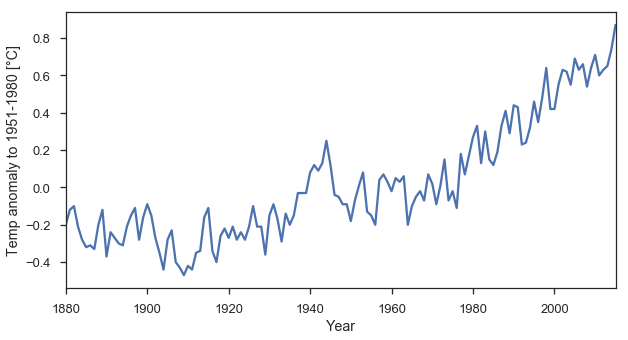

In [6]:
ax = ts.plot(figsize=(9, 5));
ax.set_ylabel('Temp anomaly to 1951-1980 [°C]');
plt.tight_layout()
plt.savefig('ts_giss.png', dpi=150)

### Trend analysis 

In [7]:
# the trend are computed on time series at least 20yrs long
start_years = ts.index[:-20]
end_years = ts.index[20:]
ny = len(start_years)
extent = (start_years[0], start_years[-1], end_years[0], end_years[-1])  # needed for the plot later

In [8]:
# fill the triangle
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny)) 
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val

### FDR threshold 

Let's see what we get as new threshold in this case:

In [9]:
# keep only our triangle, not the full square
p_fdr = fdr_threshold(sig[np.isfinite(trend)])
print('Our new threshold is {:.2}'.format(p_fdr))

Our new threshold is 0.042


So indeed less than the original 0.05.

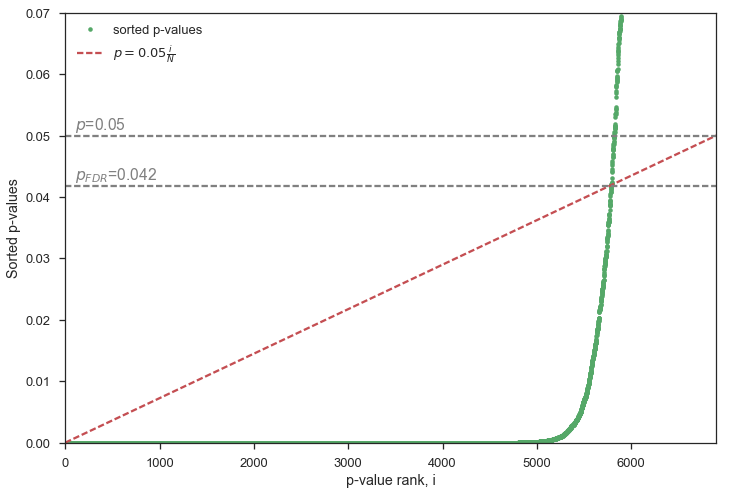

In [10]:
plot_fdr_threshold(sig[np.isfinite(trend)])
plt.savefig('pfdr_giss.png', dpi=150)

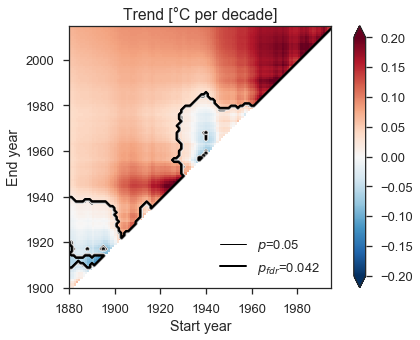

In [11]:
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.2, vmax=0.2)
c1 = plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
c2 = plt.contour(start_years, end_years, sig < p_fdr, linewidths=2)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade]');
plt.xlabel('Start year');
plt.ylabel('End year');
handles = [mlines.Line2D([], [], color='k', linewidth=1, label='$p$=0.05'), 
           mlines.Line2D([], [], color='k', linewidth=2, label='$p_{fdr}$=' + '{:.2}'.format(p_fdr))]
plt.legend(handles=handles, loc='lower right')
plt.tight_layout()
plt.savefig('triangle_giss_fdr.png', dpi=150)

In [12]:
print('{:.1%} of the triangle has a significant trend at 0.05.'.format(np.sum(sig <= 0.05) / np.sum(np.isfinite(trend))))
print('{:.1%} of the triangle has a significant trend at p_fdr.'.format(np.sum(sig <= p_fdr) / np.sum(np.isfinite(trend))))

84.3% of the triangle has a significant trend at 0.05.
83.9% of the triangle has a significant trend at p_fdr.


## Random case 

We make a fake global temperature timeseries which has the same variance as the real one. We assume normality (which is far from reality...):

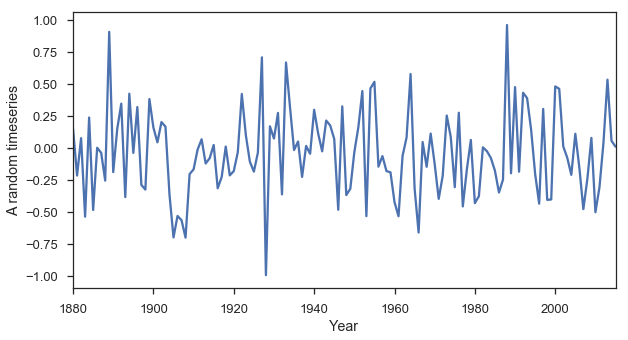

In [13]:
np.random.seed(12)  # for reproducible results
fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
ax = fake_ts.plot(figsize=(9, 5));
ax.set_ylabel('A random timeseries');
plt.tight_layout()
plt.savefig('ts_random.png', dpi=150)

In [14]:
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny))
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = fake_ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val

In [15]:
# keep only our triangle, not the full square
p_fdr = fdr_threshold(sig[np.isfinite(trend)])
print('Our new threshold is {:.2}'.format(p_fdr))

Our new threshold is 0.0


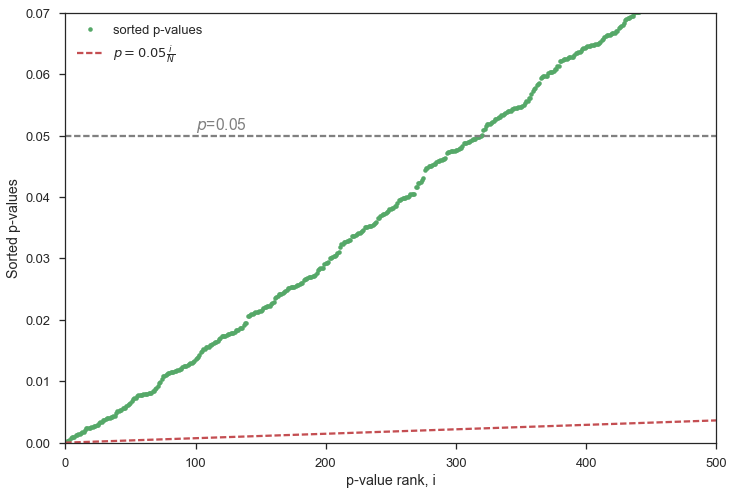

In [16]:
plot_fdr_threshold(sig[np.isfinite(trend)])
plt.xlim(0, 500)
plt.savefig('pfdr_random_a.png', dpi=150)

In [17]:
print('{:.1%} of the triangle has a significant trend at 0.05.'.format(np.sum(sig <= 0.05) / np.sum(np.isfinite(trend))))
print('{:.1%} of the triangle has a significant trend at p_fdr.'.format(np.sum(sig <= p_fdr) / np.sum(np.isfinite(trend))))

4.6% of the triangle has a significant trend at 0.05.
0.0% of the triangle has a significant trend at p_fdr.


### "Extreme" example: 

Our new threshold is 0.0063
32.4% of the triangle has a significant trend at 0.05.
12.7% of the triangle has a significant trend at p_fdr.


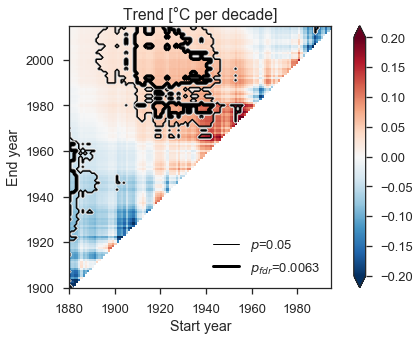

In [18]:
np.random.seed(0)  # for reproducible results
fake_ts = pd.Series(np.random.normal(0., np.std(ts), len(ts)), index=ts.index)
trend = np.zeros((ny, ny)) * np.NaN
sig = np.ones((ny, ny))
for i, start_year in enumerate(start_years):
    for j, end_year in enumerate(end_years):
        data = fake_ts.loc[start_year:end_year]
        if len(data) < 20:
            continue
        slope, _, _, p_val, _ = stats.linregress(data.index, data.values)
        trend[j, i] = slope * 10  # for decadal trends
        sig[j, i] = p_val
# keep only our triangle, not the full square
p_fdr = fdr_threshold(sig[np.isfinite(trend)])
print('Our new threshold is {:.2}'.format(p_fdr))
# plot
plt.figure(figsize=(7, 5))
im = plt.imshow(trend, extent=extent, interpolation='none', origin='lower', cmap=cmap, vmin=-0.2, vmax=0.2)
c1 = plt.contour(start_years, end_years, sig < 0.05, linewidths=1)
c2 = plt.contour(start_years, end_years, sig < p_fdr, linewidths=3)
plt.colorbar(im, extend='both');
plt.title('Trend [°C per decade]');
plt.xlabel('Start year');
plt.ylabel('End year');
handles = [mlines.Line2D([], [], color='k', linewidth=1, label='$p$=0.05'), 
           mlines.Line2D([], [], color='k', linewidth=3, label='$p_{fdr}$=' + '{:.2}'.format(p_fdr))]
plt.legend(handles=handles, loc='lower right')
plt.tight_layout()
print('{:.1%} of the triangle has a significant trend at 0.05.'.format(np.sum(sig <= 0.05) / np.sum(np.isfinite(trend))))
print('{:.1%} of the triangle has a significant trend at p_fdr.'.format(np.sum(sig <= p_fdr) / np.sum(np.isfinite(trend))))
plt.savefig('triangle_random_fdr.png', dpi=150)

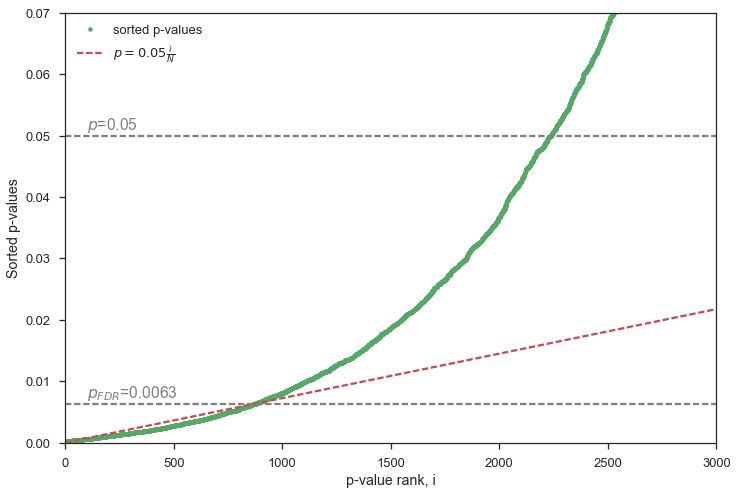

In [19]:
plot_fdr_threshold(sig[np.isfinite(trend)])
plt.xlim(0, 3000)
plt.savefig('pfdr_random_b.png', dpi=150)